# RFM Segmentasyonu / Analizi

RFM müşterileri segmentlemek, mevcut durumu gözlemlemek amacıyla uygulanan bir metoddur. 

•	Recency: Genel anlamda, ‘müşterinin son alışverişinden bugüne kadar geçen zaman’ olarak tanımlanabilir. Sadece alışveriş olarak değil, müşterinin websitemizi en son ne zaman ziyaret ettiği, en son call center arama tarihinden bugüne kadar geçen zaman da olabilir. Müşteri bazında (Bugünün tarihi-Son ziyaret tarihi) olarak hesaplanır.

•	Frequency: Müşterinin alışveriş sıklığı olarak tanımlanabilir. Yine, ziyaret sıklığı gibi farklı tanımlamalar da kabul edilebilir. İhtiyaca göre bu işlem farklılaşır. Genellikle ham sipariş datası üzerinde çalışırken, sipariş numarası kişi bazında saydırılır.

•	Monetary: Müşterinin ne kadar harcama yaptığıdır. Müşteri bazında getirdiği ciro toplanır.

Bazı çalışmalarda, RFM'e yeni metrikler eklendiğini görüyoruz.

•	Tenure: Bir müşterinin sitemizle/ şirketimizle ilk temasından bu yana geçen zamandır. İlk üye olduğu tarih, ilk alışveriş yaptığı tarih olarak kabul edilebilir.

In [1]:
#Ortamımızı belirliyoruz
import os 
os.getcwd()
path='C:\\Users\\sena.dereli\Desktop'
os.chdir(path)

#Kütüphaneleri yüklüyoruz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Datayı yüklüyoruz
data = pd.read_csv('data2.csv',encoding = 'unicode_escape')

#Toplam harcamayı sütun olarak ekliyoruz
data['TotalPrice'] = data['Price']*data['Quantity']

#Sipariş tarihinin veri tipini değiştiriyoruz
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

#Bugünü/ analiz tarihini değişken olarak belirliyoruz
today = dt.datetime(2012,1,1)
print(today)

#0'dan büyük değerleri alıyoruz.
data = data[data['Quantity'] > 0]
data = data[data['TotalPrice'] > 0]

2012-01-01 00:00:00


In [2]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [3]:
#Recency ve Monetary değerleri buluyoruz.
data_x = data.groupby('Customer ID').agg({'TotalPrice': lambda x: x.sum(),
                                        'InvoiceDate': lambda x: (today - x.max()).days})
#Data StockCode bazında olduğu için, InvoiceNo'yu unique hale getiriyoruz.
data_y = data.groupby(['Customer ID','Invoice']).agg({'TotalPrice': lambda x: x.sum()})

#Saydırdığımızda InvoiceNo unique halde gelmiş oluyor.
data_z = data_y.groupby('Customer ID').agg({'TotalPrice': lambda x: len(x)})

#RFM tablosuna ulaşmış oluyoruz.
rfm_table= pd.merge(data_x,data_z, on='Customer ID')

#Sütun isimlerini belirliyoruz
rfm_table.rename(columns= {'InvoiceDate': 'Recency',
                          'TotalPrice_y': 'Frequency',
                          'TotalPrice_x': 'Monetary'}, inplace= True)

In [4]:
rfm_table.head()

,Monetary,Recency,Frequency
Customer ID,,,
12346.0,77556.46,347,12.0
12347.0,5633.32,24,8.0
12348.0,2019.40,97,5.0
12349.0,4428.69,40,4.0
12350.0,334.40,332,1.0


In [5]:
#Frequency bulma
def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 0
    elif x <= d[p][0.40]:
        return 1
    elif x <= d[p][0.60]: 
        return 2
    elif x <= d[p][0.80]:
        return 3
    else:
        return 4

quantiles = rfm_table.quantile(q=[0.20,0.40,0.60,0.80])
quantiles = quantiles.to_dict()
rfm_table['Freq_Tile'] = rfm_table['Frequency'].apply(RScore, args=('Frequency',quantiles,))

#Recency bulma
rfm_table = rfm_table.sort_values('Recency',ascending=True)
rfm_table['Rec_Tile'] = pd.qcut(rfm_table['Recency'],5,labels=False)

#Monetary bulma
#rfm_table.sort_values('Monetary',ascending=False)
rfm_table['Mone_Tile'] = pd.qcut(rfm_table['Monetary'],5,labels=False)

#'Sıfır' değeri yer almasın istiyorsak, bulduğumuz değerleri 1 arttırıyoruz
rfm_table['Rec_Tile'] = rfm_table['Rec_Tile'] + 1
rfm_table['Freq_Tile'] = rfm_table['Freq_Tile'] + 1
rfm_table['Mone_Tile'] = rfm_table['Mone_Tile'] + 1

#Bulduğumuz değerleri birleştirip tek bir skor elde ediyoruz
rfm_table['RFM Score'] = rfm_table['Rec_Tile'].map(str) + rfm_table['Freq_Tile'].map(str) + rfm_table['Mone_Tile'].map(str)
rfm_table.head()

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
Customer ID,,,,,,,
12433.0,20581.26,22,10.0,5,1,5,155
14051.0,22434.00,22,37.0,5,1,5,155
17581.0,18757.75,22,43.0,5,1,5,155
13069.0,9683.13,22,38.0,5,1,5,155
16558.0,13873.51,22,38.0,5,1,5,155


In [6]:
#Değerlerin içeriklerini inceliyoruz.
rfm_table.groupby('RFM Score').agg({
'Recency': ['mean','min','max','count'],
'Frequency': ['mean','min','max','count'],
'Monetary': ['mean','min','max','count'] }).round(1).head()

Recency               Frequency                 Monetary          \
             mean min max count      mean  min  max count     mean     min   
RFM Score                                                                    
111          33.6  23  41    42       1.0  1.0  1.0    42    173.9    43.2   
112          32.4  23  41    29       1.0  1.0  1.0    29    380.4   301.3   
113          31.4  22  40     5       1.0  1.0  1.0     5    895.5   681.0   
115          24.0  24  24     1       1.0  1.0  1.0     1   3861.0  3861.0   
121          31.0  23  41    22       2.0  2.0  2.0    22    209.7    77.4   

                         
              max count  
RFM Score                
111         285.6    42  
112         546.0    29  
113        1201.5     5  
115        3861.0     1  
121         284.5    22

In [7]:
rfm_table.groupby('RFM Score').size().sort_values(ascending=False)[:10]

RFM Score
155    473
511    446
411    243
255    238
512    213
344    160
244    143
412    135
144    134
355    132
dtype: int64

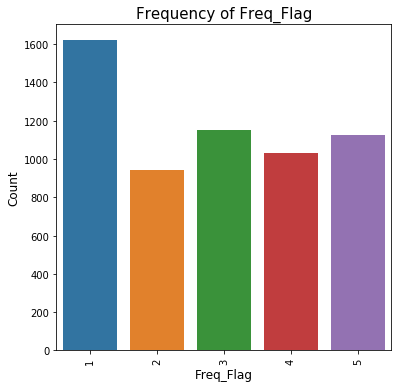

In [8]:
plt.figure(figsize=(6,6))
sns.countplot(x='Freq_Tile', data=rfm_table)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Freq_Flag', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of Freq_Flag', fontsize=15)
plt.show()

# K-Means Segmentasyonu

Gözetimsiz öğrenme algoritmalarından biridir. 
Amaç: Datayı belirli özelliklerine göre ayırıp, karakteristik özelliklerini çıkartmak.
      Noktalar arası uzaklık toplamını minimize etmek. Kümeler arası uzaklığı maksimize etmek.



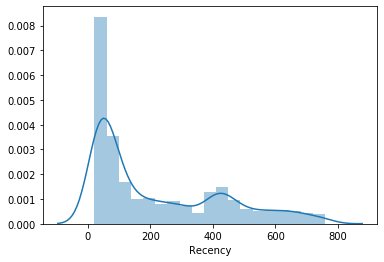

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.distplot(rfm_table['Recency'])
plt.show()

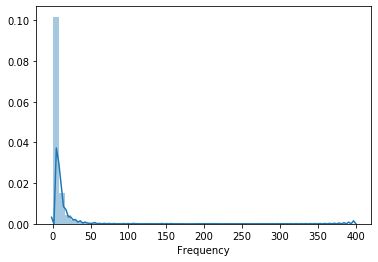

In [10]:
sns.distplot(rfm_table['Frequency'])

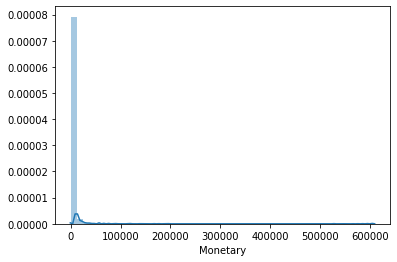

In [11]:
sns.distplot(rfm_table['Monetary'])

In [12]:
rfm_table.head()

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
Customer ID,,,,,,,
12433.0,20581.26,22,10.0,5,1,5,155
14051.0,22434.00,22,37.0,5,1,5,155
17581.0,18757.75,22,43.0,5,1,5,155
13069.0,9683.13,22,38.0,5,1,5,155
16558.0,13873.51,22,38.0,5,1,5,155


In [13]:
clus = rfm_table[['Monetary','Recency','Frequency']]

In [14]:
clus.head()

,Monetary,Recency,Frequency
Customer ID,,,
12433.0,20581.26,22,10.0
14051.0,22434.00,22,37.0
17581.0,18757.75,22,43.0
13069.0,9683.13,22,38.0
16558.0,13873.51,22,38.0


In [15]:
clusterdata=clus.iloc[:,0:4]
clusterdata.head()

,Monetary,Recency,Frequency
Customer ID,,,
12433.0,20581.26,22,10.0
14051.0,22434.00,22,37.0
17581.0,18757.75,22,43.0
13069.0,9683.13,22,38.0
16558.0,13873.51,22,38.0


In [16]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(clus)
data_scaled2 = pd.DataFrame(x_scaled)


In [17]:
data_scaled2.head()

,0,1,2
0,0.033800,0.0,0.022670
1,0.036844,0.0,0.090680
2,0.030805,0.0,0.105793
3,0.015900,0.0,0.093199
4,0.022783,0.0,0.093199


In [18]:
data_scaled2.describe()

,0,1,2
count,5878.000000,5878.000000,5878.000000
mean,0.004953,0.272177,0.013323
std,0.024207,0.283677,0.032769
min,0.000000,0.000000,0.000000
25%,0.000568,0.033875,0.000000
50%,0.001472,0.128726,0.005038
75%,0.003785,0.513550,0.015113
max,1.000000,1.000000,1.000000


In [19]:
?KMeans

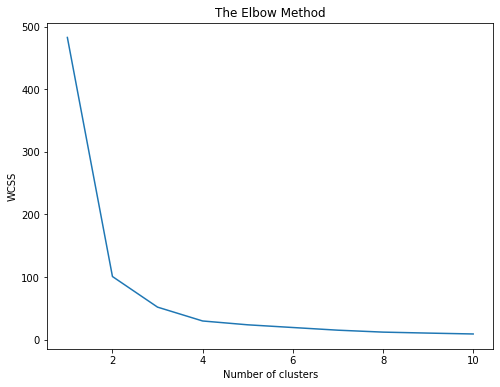

In [21]:
plt.figure(figsize=(8,6))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',n_init=10, max_iter = 300)
    kmeans.fit(data_scaled2)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [22]:
from sklearn.metrics import silhouette_score
inertia_list=[]
silhouette_score_list=[]
for i in range (2,10):
    #kmeans = KMeans(init='k-means++', n_clusters=i, n_init=10, max_iter = 300)
    kmeans.fit(data_scaled2)
    silhouette_score_list.append(silhouette_score(data_scaled2,kmeans.labels_))
    print(silhouette_score_list)

[0.5362929233233433]
[0.5362929233233433, 0.5353157850034473]
[0.5362929233233433, 0.5353157850034473, 0.5338984488862861]
[0.5362929233233433, 0.5353157850034473, 0.5338984488862861, 0.5336889085601951]
[0.5362929233233433, 0.5353157850034473, 0.5338984488862861, 0.5336889085601951, 0.5331336600529272]
[0.5362929233233433, 0.5353157850034473, 0.5338984488862861, 0.5336889085601951, 0.5331336600529272, 0.5358608479859147]
[0.5362929233233433, 0.5353157850034473, 0.5338984488862861, 0.5336889085601951, 0.5331336600529272, 0.5358608479859147, 0.5328629691584896]
[0.5362929233233433, 0.5353157850034473, 0.5338984488862861, 0.5336889085601951, 0.5331336600529272, 0.5358608479859147, 0.5328629691584896, 0.5317123034440572]


In [23]:
# k means using 3 clusters and k-means++ initialization
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init =10,max_iter = 300)
kmeans.fit(data_scaled2)
pred = kmeans.predict(data_scaled2)

In [24]:
pred = kmeans.predict(data_scaled2)

In [25]:
d_frame = pd.DataFrame(clus)
d_frame['cluster'] = pred
d_frame['cluster'].value_counts()

0    3144
3    1110
2     987
1     637
Name: cluster, dtype: int64

In [26]:
d_frame.head()

,Monetary,Recency,Frequency,cluster
Customer ID,,,,
12433.0,20581.26,22,10.0,0
14051.0,22434.00,22,37.0,0
17581.0,18757.75,22,43.0,0
13069.0,9683.13,22,38.0,0
16558.0,13873.51,22,38.0,0


In [27]:
d_frame.groupby('cluster').mean()

,Monetary,Recency,Frequency
cluster,,,
0,4709.767538,59.391539,9.310433
1,619.254854,643.648352,1.551020
2,1417.731738,234.436677,3.737589
3,1028.967091,434.136036,2.720721


# Association Rules - Birliktelik Analizi

In [28]:
!pip install mlxtend

In [29]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [30]:
data_apriori = data[data['Country']=='United Kingdom']

In [31]:
data_apr = data_apriori.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')

In [32]:
data_apr.head()

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
def num(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_new = data_apr.applymap(num)

In [34]:
basket_new.head()

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
from mlxtend.frequent_patterns import fpgrowth

rule_fp = fpgrowth(basket_new, min_support=0.02, use_colnames=True)
rule_fp

,support,itemsets
0,0.055707,(STRAWBERRY CERAMIC TRINKET BOX)
1,0.073254,(ASSORTED COLOUR BIRD ORNAMENT)
2,0.054628,(HOME BUILDING BLOCK WORD)
3,0.045060,(LOVE BUILDING BLOCK WORD)
4,0.042788,(SCOTTIE DOG HOT WATER BOTTLE)
...,...,...
205,0.022203,"(JUMBO BAG STRAWBERRY, JUMBO BAG RED RETROSPOT)"
206,0.021380,"(LUNCH BAG SPACEBOY DESIGN , LUNCH BAG BLACK ..."
207,0.025866,"(HEART OF WICKER SMALL, HEART OF WICKER LARGE)"
208,0.020613,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC..."


In [36]:
items = apriori(basket_new, min_support=0.02, use_colnames=True)

In [37]:
rule = association_rules(items, metric="lift", min_threshold=1)
rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PACK OF 60 PINK PAISLEY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.045940,0.050511,0.022061,0.480222,9.507272,0.019741,1.826722
1,(60 TEATIME FAIRY CAKE CASES),(PACK OF 60 PINK PAISLEY CAKE CASES),0.050511,0.045940,0.022061,0.436762,9.507272,0.019741,1.693885
2,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.026349,0.028592,0.020613,0.782328,27.362043,0.019860,4.462707
3,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.028592,0.026349,0.020613,0.720953,27.362043,0.019860,3.489206
4,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.053407,0.051562,0.025866,0.484317,9.392973,0.023112,1.839188
5,(HEART OF WICKER LARGE),(HEART OF WICKER SMALL),0.051562,0.053407,0.025866,0.501652,9.392973,0.023112,1.899461
6,(LOVE BUILDING BLOCK WORD),(HOME BUILDING BLOCK WORD),0.045060,0.054628,0.023481,0.521109,9.539220,0.021019,1.974086
7,(HOME BUILDING BLOCK WORD),(LOVE BUILDING BLOCK WORD),0.054628,0.045060,0.023481,0.429834,9.539220,0.021019,1.674845
8,(JUMBO BAG STRAWBERRY),(JUMBO BAG RED RETROSPOT),0.046139,0.073140,0.022203,0.481231,6.579560,0.018829,1.786651
9,(JUMBO BAG RED RETROSPOT),(JUMBO BAG STRAWBERRY),0.073140,0.046139,0.022203,0.303571,6.579560,0.018829,1.369647
